**Role:** data scientist at Airbnb

**Project Description:**
a start-up that lists properties on behalf of Airbnb hosts.

**Data Description:**
1.	dataset airbnb_listings_information.csv includes the details for a sample of historic Airbnb listings for London.
2.	data_dictionary_airbnb.xlsx data dictionary describing the fields within the dataset. 

**Problem Statement:**
The firm intends to use a model to advise their clients on how to set a competitive price for their first listing on Airbnb. The model must predict the expected price of a new listing using at least the features of the property itself (including location and amenities) and listing parameters (e.g. min nights, accommodates and availabilities). 

**Objective:**
To prepare a model to advise the clients to set competitive price for their first listing on Airbnb based on the features of the property (including location and amenities) and listing parameters (e.g. min nights, accommodates and availabilities). 


In [1]:
# Import Package and Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch   # Used for reordering the correlation matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math,time,joblib
from datetime import datetime
import string,re


import sklearn 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Acquisition

In [2]:
#define path of data folder and read dataset
data_path = 'D:/'

data = pd.read_csv(data_path+'airbnb_listings_information_processed.csv', encoding = 'utf8')

In [3]:
#sample data
data.head()

,host_response_time,room_type,host_is_superhost,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,review_scores_rating,...,Entertainment,Kitchen and dining,Internet and office,Bathroom,Bedroom and laundry,safety,Facilities,Heating and cooling,number_of_amenities,property
0,hour,Entire home/apt,0,4,1,3,105.0,2,35,91.0,...,1,1,1,1,1,1,1,1,28,apartment
1,hours,Private room,0,2,1,1,40.0,1,21,97.0,...,1,1,1,1,1,1,1,1,41,apartment
2,unknown,Entire home/apt,0,2,1,1,75.0,7,35,96.0,...,1,1,1,1,1,1,1,1,24,apartment
3,days,Entire home/apt,1,6,3,3,307.0,4,35,94.0,...,1,1,1,1,1,0,1,1,27,apartment
4,unknown,Private room,0,2,1,1,150.0,3,0,0.0,...,1,0,1,1,1,0,1,1,16,townhouse


### Define Target

- Prediction Type: forecasting
- Target Variable: log_price

In [4]:
X = data.drop('price_per_room',axis=1)
y = data['price_per_room']

In [5]:
categorical_columns = list(X.select_dtypes(include=[object]).columns)

In [6]:
categorical_columns

['host_response_time',
 'room_type',
 'host_country_status',
 'host_city_status',
 'host_verifications_status',
 'Property_Location',
 'property']

# Feature Handling
### Data Encoding

In [7]:
# Import label encoder 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

X[['Property_Location','property']] = X[['Property_Location','property']].apply(label_encoder.fit_transform)

In [8]:
X = pd.get_dummies(X)

In [9]:
X.columns

Index(['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'log_price', 'number_of_nearby',
       'Property_Location', 'Entertainment', 'Kitchen and dining',
       'Internet and office', 'Bathroom', 'Bedroom and laundry', 'safety',
       'Facilities', 'Heating and cooling', 'number_of_amenities', 'property',
       'host_response_time_day', 'host_response_time_days',
       'host_response_time_hour', 'host_response_time_hours',
       'host_response_time_unknown', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_country_status_Aboard',
       'host_country_status_Native', 'host_city_status_London',
       'host_city_status_Other', 'host_verifications_status_Not Verified',
       'host_verifications_status_Verified'],
      dtype='object')

# Feature Selection

host_is_superhost      -0.017011
accommodates            0.136096
bedrooms               -0.003208
beds                    0.077211
price                   0.762274
minimum_nights          0.006596
number_of_reviews      -0.066197
review_scores_rating   -0.091157
instant_bookable        0.058276
log_price               0.609423
price_per_room          1.000000
number_of_nearby        0.085748
Entertainment           0.167881
Kitchen and dining     -0.052468
Internet and office    -0.004727
Bathroom                0.044332
Bedroom and laundry     0.033318
safety                  0.079890
Facilities              0.008325
Heating and cooling    -0.062955
number_of_amenities     0.055437
Name: price_per_room, dtype: float64


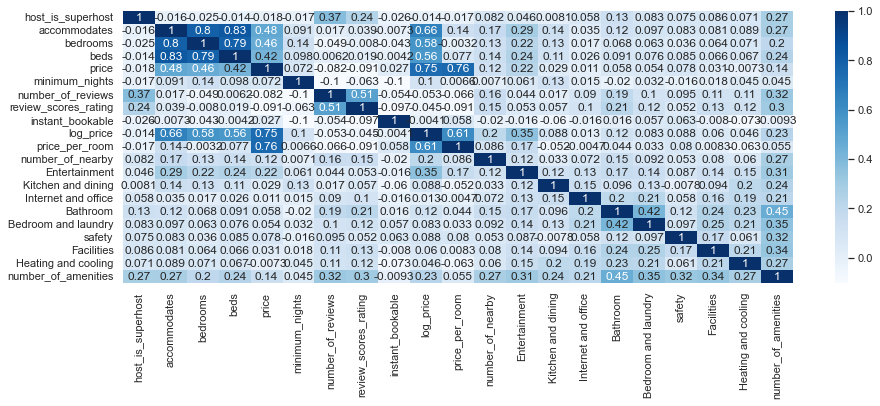

In [10]:
# check correlation between features

#Plot histogram is a representation of the distribution of dataset.
sns.set(rc={'figure.figsize':(15,5)})

# check correlation between the features
corr = data.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
print(corr['price_per_room'])

<AxesSubplot:>

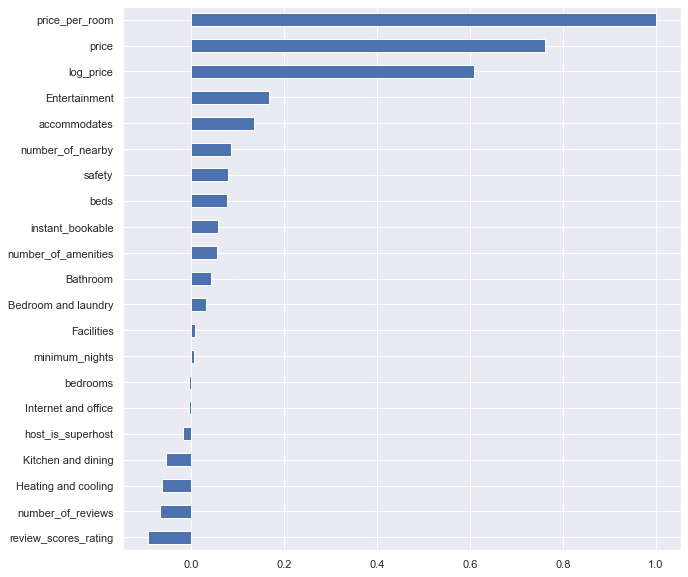

In [11]:
plt.figure(figsize=(10,10))
data.corr()["price_per_room"].sort_values().plot(kind="barh")


#### Initial Feature Elimination:
eliminated 'bedrooms','Internet and office','Facilities','minimum_nights'

In [12]:
data = data.drop(['bedrooms','Internet and office','Facilities','minimum_nights'],axis=1)

In [13]:
data.columns

Index(['host_response_time', 'room_type', 'host_is_superhost', 'accommodates',
       'beds', 'price', 'number_of_reviews', 'review_scores_rating',
       'instant_bookable', 'log_price', 'price_per_room', 'number_of_nearby',
       'host_country_status', 'host_city_status', 'host_verifications_status',
       'Property_Location', 'Entertainment', 'Kitchen and dining', 'Bathroom',
       'Bedroom and laundry', 'safety', 'Heating and cooling',
       'number_of_amenities', 'property'],
      dtype='object')

### Define Train and Test Dataset

In [14]:
# split data into Train and Validate dataset
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Data Scaling

In [15]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scalar.fit_transform(X_test), columns=X_test.columns)
X_train_scaled.shape,X_test_scaled.shape

((53448, 37), (22907, 37))

In [16]:
#Lasso Regression for Feature Selection
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X_train_scaled,y_train)

print("Best alpha %f" % reg.alpha_)
print("Best score %f" % reg.score(X_train_scaled,y_train))

coef = pd.Series(reg.coef_, index = X_train_scaled.columns)

mask=reg.coef_!=0
X_train_selected=X_train_scaled.loc[:,mask]
X_train_selected

Best alpha 0.052508
Best score 0.800883


,host_is_superhost,accommodates,bedrooms,beds,price,minimum_nights,review_scores_rating,instant_bookable,log_price,number_of_nearby,...,host_response_time_hour,host_response_time_hours,host_response_time_unknown,room_type_Entire home/apt,room_type_Shared room,host_country_status_Aboard,host_country_status_Native,host_city_status_London,host_verifications_status_Not Verified,host_verifications_status_Verified
0,-0.409762,-0.587137,-0.609538,-0.764221,-0.511605,2.132829,-1.461643,-0.750722,-0.727267,-0.631518,...,-0.582161,-0.334482,-1.035389,0.905129,-0.086177,1.545085,-1.545085,-1.207313,0.031506,-0.031506
1,-0.409762,-0.587137,-0.609538,-0.764221,-0.323003,2.132829,-1.461643,-0.750722,-0.167134,-0.326226,...,-0.582161,2.989693,-1.035389,0.905129,-0.086177,-0.647214,0.647214,0.828285,0.031506,-0.031506
2,-0.409762,0.605660,-0.609538,0.534583,0.103401,2.132829,0.815257,-0.750722,0.603487,-0.631518,...,-0.582161,-0.334482,0.965821,0.905129,-0.086177,1.545085,-1.545085,0.828285,0.031506,-0.031506
3,-0.409762,-0.587137,-0.609538,-0.764221,-0.224602,-0.906793,0.815257,-0.750722,0.053366,0.589649,...,-0.582161,-0.334482,0.965821,0.905129,-0.086177,1.545085,-1.545085,-1.207313,0.031506,-0.031506
4,2.440441,-1.183536,-0.609538,-0.764221,-0.634606,0.106414,0.746950,-0.750722,-1.277388,-0.631518,...,1.717738,-0.334482,-1.035389,-1.104815,-0.086177,-0.647214,0.647214,0.828285,0.031506,-0.031506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53443,2.440441,-0.587137,-0.609538,-0.764221,-0.593606,-0.400189,0.815257,1.332050,-1.068242,0.894941,...,-0.582161,-0.334482,0.965821,-1.104815,-0.086177,-0.647214,0.647214,0.828285,0.031506,-0.031506
53444,-0.409762,-0.587137,-0.609538,-0.764221,-0.634606,-0.906793,0.587567,-0.750722,-1.277388,-0.631518,...,-0.582161,-0.334482,0.965821,-1.104815,-0.086177,-0.647214,0.647214,0.828285,0.031506,-0.031506
53445,-0.409762,-0.587137,-0.609538,-0.764221,-0.536205,-0.906793,0.701412,1.332050,-0.820874,-0.631518,...,1.717738,-0.334482,-1.035389,0.905129,-0.086177,1.545085,-1.545085,-1.207313,0.031506,-0.031506
53446,-0.409762,1.798457,0.883385,1.833387,0.349404,-0.400189,0.815257,-0.750722,0.906240,-0.631518,...,-0.582161,-0.334482,0.965821,0.905129,-0.086177,-0.647214,0.647214,0.828285,0.031506,-0.031506


In [17]:
Selected_Features = X_train_selected.columns
X_test_selected = X_test_scaled[Selected_Features]

In [18]:
len(Selected_Features)

31

# Define Model Evaluation Metric

In [19]:
def PerformanceMetric(Model,y_test,y_pred):

    rsquare = r2_score(y_test,y_pred)
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = math.sqrt(mean_squared_error(y_test,y_pred))
    MAE = mean_absolute_error(y_test,y_pred)
    
    print('Testing rsquare_score:',rsquare)
    print('Testing Mean Squared Error:', MSE)
    print('Testing Root Mean Squared Error:', RMSE)
    print('Testing Mean Absolute Error:', MAE)
    
    return rsquare,MSE,RMSE,MAE

In [20]:
PerformanceResults = []

In [21]:
from sklearn.linear_model import LinearRegression
Start_time = time.time() 
lm = LinearRegression()

lm.fit(X_train_selected, y_train)

y_predict = lm.predict(X_test_selected)

rsquare,MSE,RMSE,MAE = PerformanceMetric(lm,y_test,y_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Linear Regression',rsquare,MSE,RMSE,MAE, time.time()-Start_time])

Testing rsquare_score: 0.8041593020429652
Testing Mean Squared Error: 1072.679132669227
Testing Root Mean Squared Error: 32.75178060303328
Testing Mean Absolute Error: 13.408912041033352
Model Train Time Taken: 0.0655372142791748


In [22]:
from sklearn.ensemble import GradientBoostingRegressor
Start_time = time.time() 

GB = GradientBoostingRegressor(random_state=42,max_depth=5)

GB.fit(X_train_selected, y_train)
y_predict = GB.predict(X_test_selected)

rsquare,MSE,RMSE,MAE = PerformanceMetric(GB,y_test,y_predict)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['Gradient Boosting Regressor',rsquare,MSE,RMSE,MAE, time.time()-Start_time])

Testing rsquare_score: 0.9868172518247342
Testing Mean Squared Error: 72.20592566486464
Testing Root Mean Squared Error: 8.497406996541041
Testing Mean Absolute Error: 1.5222171850277209
Model Train Time Taken: 9.946935176849365


In [23]:
from xgboost import XGBRegressor
XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

XGB.fit(X_train_selected, y_train)
predictions = XGB.predict(X_test_selected)

rsquare,MSE,RMSE,MAE = PerformanceMetric(XGB,y_test,predictions)
print('Model Train Time Taken:',time.time()-Start_time)
PerformanceResults.append(['XGB Regressor',rsquare,MSE,RMSE,MAE, time.time()-Start_time])

Testing rsquare_score: 0.9670701397150544
Testing Mean Squared Error: 180.36687132887877
Testing Root Mean Squared Error: 13.430073392535082
Testing Mean Absolute Error: 2.020951197303433
Model Train Time Taken: 53.77120065689087


In [24]:
Report = pd.DataFrame(PerformanceResults,columns=['Model','rsquare_score','Mean Squared Error','Root Mean Squared Error','Mean Absolute Error','TrainingTime'])
Report

,Model,rsquare_score,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,TrainingTime
0,Linear Regression,0.804159,1072.679133,32.751781,13.408912,0.065537
1,Gradient Boosting Regressor,0.986817,72.205926,8.497407,1.522217,9.946935
2,XGB Regressor,0.967070,180.366871,13.430073,2.020951,53.771201


# Model Assessment:
The Gradient Boosting Regressor Model rsquare_score is highest and Root Mean Squared Error is lowest as compared to other model. Therefore, Gradient Boosting Regressor Model is the best model based on performance comparisons.

In [25]:
joblib.dump(GB,'Airbnb_price_forecasting_model.pkl')

['Airbnb_price_forecasting_model.pkl']